## 1. Import Relevant Libraries and Reading In of User's Dataset

* 1a. Importing Relevant Libraries

In [53]:
# Import Required Libaries
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from keras.layers import Bidirectional
import math 
import gdown


* 1b. Reading in User's Data:


## ** To User: Please load your dataset here

> Insert your Dataset file path in the next cell:

In [54]:
# FD001 (Dataset 1)

## Note: here, we are assuming that the training set of FD001 is the user's dataset

train1 = "/content/train_FD001.txt"

> 1c. Data is being read in ...

In [55]:
# For FD001
# Train Data 
train1_df = pd.read_csv(train1, sep=" ", header=None)


* 1d. We load the trained Deep Learning Model here: 

In [56]:
# import model
# This URL contains the trained model:
url = 'https://drive.google.com/uc?id=1lCDBubTqPwyDo0j3Kt0XrAkdTltZrlJz'

## ** To User: Please enter your desired output file path in the next cell

> Import the model to your desired output file path:

In [57]:
# Insert your desired output file path here:
output = '/content/deep_learning_model.h5'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lCDBubTqPwyDo0j3Kt0XrAkdTltZrlJz
To: /content/deep_learning_model.h5
100%|██████████| 257k/257k [00:00<00:00, 46.1MB/s]


'/content/deep_learning_model.h5'

In [58]:
# Defining R2 to be used as an evaluation metric in the Deep Learning Model Evaluation Metrics
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

dependencies = {
    'r2_keras': r2_keras
}

model = keras.models.load_model(output, custom_objects=dependencies)

## 2. Data Preprocessing (Assuming User's Dataset is in the same format as the provided NASA CMAPSS Dataset)
- Dealing with Missing Values: Drop the last 2 columns, because they consist of all null values
- Rename columns according to the Engine ID, Cycle, the 3 respective Operating Settings and the 21 Operating Sensors. This aids in better readability and interpretability of the dataset.
- Derive RUL labels from the train data. This is because the RUL for the train data is not explicity provided.
- MinMax Normalisation to transform our features' values to a value between 0 and 1; For every feature, the minimum value of the feature would be transformed to a value of 0, and the maximum value of the feature would be transformed to a value of 1. 
- Contextual handling of RUL: Clipping the upper limit of the RUL of aircrafts to mimic a more accurate degradation pattern of the aircraft engine with increasing usage.
- Transform the input data into a form (3-Dimensional Form) that can be fed into the deep learning model. 

* 2a. Dealing with Missing Values: Drop the last 2 columns for Training, Testing and True Labels Dataframes
> This is because the last 2 columns consists of all null values.

In [59]:
# Drop the last 2 columns for Train, Test and True RUL Dataframes

# FD001
train1_df.drop(train1_df.columns[[26, 27]], axis=1, inplace=True)


* 2b. Rename Columns in this form for better readability and interpretability of the dataset: 
<br><i>-> Engine ID
<br>-> 3 Operating Settings
<br>-> 21 Sensors

In [60]:
# Rename columns into readable forms, namely, by: 
# [Engine ID, Operational Settings, Sensors]

# FD001
train1_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train1_df = train1_df.sort_values(['id','cycle'])




* 2c. Derive RUL labels for the Training Data
<br><i> This is because the RUL for the Training Data is not explicity provided.

Since this dataset is a simulated run-to-failure dataset, the last row for each Engine ID would represent the last cycle of the engine, indicating aircraft failure had already occurred. Hence, since we already know the complete life cycle length of Engines, we employed the following calculations for RUL derivation:
> * RUL (of each row/instance of each Engine ID) = Maximum cycle length for each Engine ID - current cycle length (at each row/instance of each Engine ID)


In [61]:
# Function to derive the RUL labels for the Train Data
def extract_rul(data, factor = 0):

    # Get the total number of cycles for each unit, i.e. Each Engine ID
    # The last row (i.e. maximum value) for each Engine ID would represent the last cycle of the engine
    rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    # Merge the maximum cycle into the original dataframe
    data = data.merge(rul, on=['id'], how='left')

    # Actual calculation of RUL (based on the maximum value of the RUL for each Engine)
    data['RUL'] = data['max'] - data['cycle']

    # Drop the 'max' column, which now does not add any value
    data.drop(columns=['max'], axis = 1, inplace = True)
  
    return data[data['cycle'] > factor]

# Apply the function on the data:
# FD001
train1_df = extract_rul(train1_df, factor = 0)

* 2d. Contextual Handling of RUL: Clipping the maximum RUL to aircraft engines for Training Data 
> This is to more accurately portray the degradation pattern of aircraft engines after a certain period of usage

In [62]:
# Clipping the maximum RUL to aircraft engines (for train data):

# FD001
train1_df['RUL'] = train1_df['RUL'].clip(upper=125)



* 2e. MinMax Normalisation of Training Data
> * Transforms our features' values to a value between 0 and 1; 
> * The minimum value of the feature would be transformed to a value of 0, and the maximum value of the feature would be transformed to a value of 1. 


In [63]:
# FD001
# MinMax normalization of Operational Settings and Sensor Values (from 0 to 1) for train set
train1_df['cycle_norm'] = train1_df['cycle']
cols_normalize = train1_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train1_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train1_df.index)
join_df = train1_df[train1_df.columns.difference(cols_normalize)].join(norm_train_df)
train1_df = join_df.reindex(columns = train1_df.columns)



* 2g: Transform data into a form that can be fed into the Deep Learning Model as input.
> The form is: [samples, time steps, features]

In [64]:
# Transforming data into a form that can be fed in to the Deep Learning Model 
# The Form is a(3 Dimensional Form): (samples, time steps, features) 

# Assign sequence length of 50 
sequence_length = 50
# Function to generate the sequence for the data: 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [65]:
# Feature columns consists of the Operational Settings and Sensor Columns: 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)


In [66]:
seq_gen = (list(gen_sequence(train1_df[train1_df['id']==id], sequence_length, sequence_cols)) 
           for id in train1_df['id'].unique())

# Generate a sequence with the gen_sequence function to get the 3-Dimensional Form 
# Convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

In [67]:
# Function to generate the RUL labels 
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# Generate the labels using the gen_labels function
label_gen = [gen_labels(train1_df[train1_df['id']==id], sequence_length, ['RUL']) 
             for id in train1_df['id'].unique()]
# Convert to numpy array
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## 3. Running the Model

In [68]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

In [69]:
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae','mse',r2_keras])

## > Fit data into the model to get the predicted RUL values
## * Predicted RUL will be output as a .csv file

In [70]:
RUL_predicted = model.predict(seq_array)
df = pd.DataFrame(RUL_predicted)
df.to_csv('predicted_RUL.csv')

## SHAP Interpretation

In [71]:
%pip install shap
import shap

In [72]:
features = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'] 

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state=0, criterion='friedman_mse')
gb_reg.fit(train1_df[features], train1_df['RUL'])


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:

# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    S = train1_df[features] 
    explainerModel = shap.TreeExplainer(gb_reg)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

> Global Interpretability

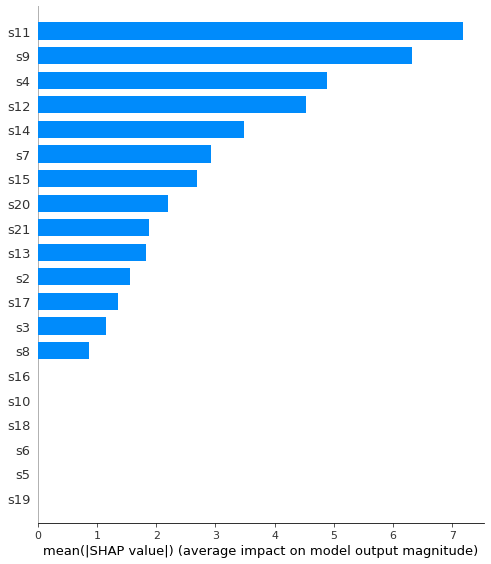

In [75]:
shap_values = shap.TreeExplainer(gb_reg).shap_values(train1_df[features])
shap.summary_plot(shap_values, train1_df[features], plot_type="bar")

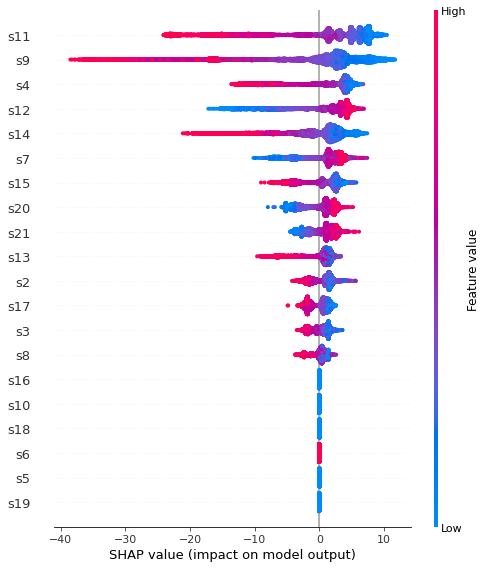

In [76]:
shap.summary_plot(shap_values, features=train1_df[features], feature_names= features)

> Local Interpretability (e.g. for Engine ID 90)

In [77]:
shap.initjs()
shap_plot(90)